# Numerical Analysis Encryption Experiment (Robust Version)

This notebook supports two input modes:
- `synthetic`: auto-generate controlled test images
- `custom`: use your own images from `data/custom_images`

Pipeline:
1. Build or load images
2. Encrypt blocks with dense/sparse keys
3. Inject Gaussian noise
4. Decrypt with Gaussian Elimination, LU, and Gauss-Seidel
5. Export reproducible metrics, plots, and LaTeX tables


In [1]:
# HOW TO RUN
# 1) pip install numpy matplotlib
# 2) Put your images in data/custom_images (png/jpg/jpeg/bmp/tif/tiff)
# 3) In CONFIG, set data_source to "custom" (or "synthetic" for auto data)
# 4) Run all cells from top to bottom
# 5) Check outputs in out/: CSV, figures, and LaTeX tables

import csv
import json
import math
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True, precision=4)


In [2]:
# =========================
# Global configuration
# =========================
CONFIG = {
    "seed": 42,
    "data_source": "custom",  # "synthetic" or "custom"
    "custom_image_dir": "data/custom_images",
    "max_custom_images": 20,
    "save_loaded_images": True,

    "image_size": 128,
    "block_size": 8,
    "num_synthetic_images": 12,

    "noise_sigmas": [0.0, 0.001, 0.005, 0.01],
    "repeats": 3,

    "gs_tol": 1e-6,
    "gs_max_iters": 200,

    "sparse_density": 0.20,
    "sigma_for_latex_table": 0.01,
}

ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
SYNTH_DIR = DATA_DIR / "synthetic"
CUSTOM_DIR = ROOT / CONFIG["custom_image_dir"]
PROCESSED_DIR = DATA_DIR / "processed"
OUT_DIR = ROOT / "out"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"

for p in [SYNTH_DIR, PROCESSED_DIR, OUT_DIR, FIG_DIR, TABLE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

if CONFIG["image_size"] % CONFIG["block_size"] != 0:
    raise ValueError("image_size must be divisible by block_size")

rng = np.random.default_rng(CONFIG["seed"])
VECTOR_SIZE = CONFIG["block_size"] * CONFIG["block_size"]

# Reproducibility snapshot
(OUT_DIR / "config.json").write_text(json.dumps(CONFIG, indent=2), encoding="utf-8")
print("Saved config:", OUT_DIR / "config.json")


Saved config: e:\Projects\Numerical-Analysis-Project\out\config.json


In [3]:
def minmax01(x):
    x = x.astype(np.float64)
    mn, mx = x.min(), x.max()
    if mx - mn < 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)


def rgb_to_gray(img):
    # Expects either HxW or HxWxC
    if img.ndim == 2:
        return img.astype(np.float64)
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float64)
    raise ValueError("Unsupported image shape")


def resize_nearest(img, out_h, out_w):
    in_h, in_w = img.shape
    row_idx = np.linspace(0, in_h - 1, out_h).astype(int)
    col_idx = np.linspace(0, in_w - 1, out_w).astype(int)
    return img[row_idx][:, col_idx]


def validate_image(img, name="unknown"):
    if img.ndim != 2:
        raise ValueError(f"{name}: expected 2D grayscale image")
    if not np.isfinite(img).all():
        raise ValueError(f"{name}: contains non-finite values")
    if img.shape[0] < 16 or img.shape[1] < 16:
        raise ValueError(f"{name}: image is too small")


Data source: custom
Number of images: 20
Image size: (128, 128)


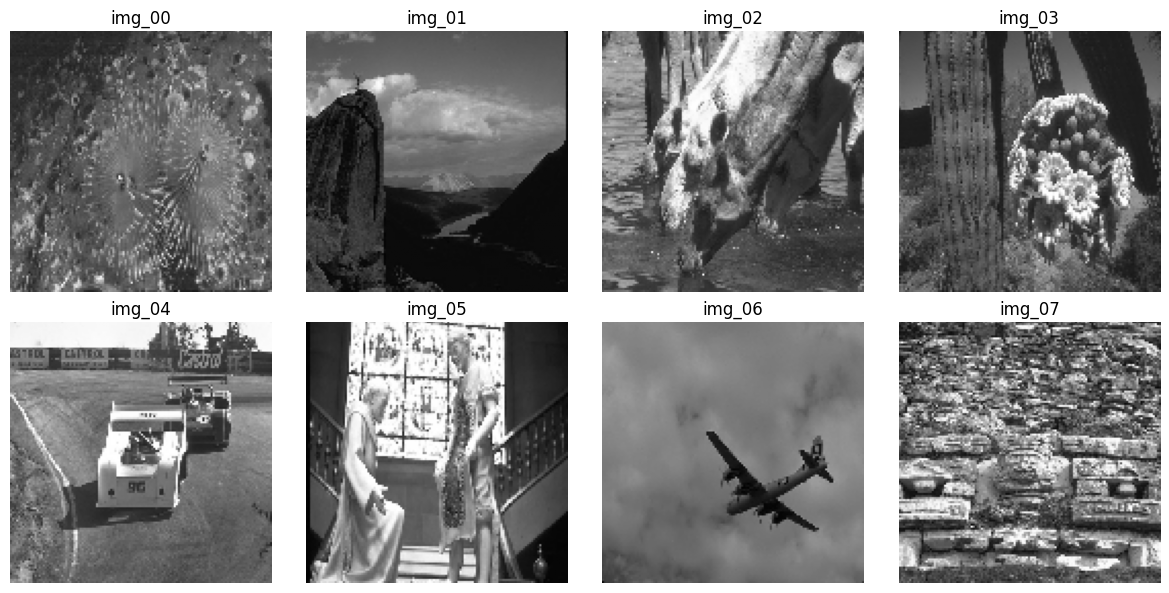

In [4]:
def generate_pattern_image(kind, size, rng):
    y, x = np.mgrid[0:size, 0:size]
    x = x / (size - 1)
    y = y / (size - 1)

    if kind % 6 == 0:
        img = 0.6 * x + 0.4 * y
    elif kind % 6 == 1:
        img = ((np.floor(x * 12) + np.floor(y * 12)) % 2).astype(float)
    elif kind % 6 == 2:
        cx, cy = 0.5 + 0.1 * rng.standard_normal(), 0.5 + 0.1 * rng.standard_normal()
        r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        img = np.cos(25 * r)
    elif kind % 6 == 3:
        img = np.sin(18 * x) * np.cos(14 * y)
    elif kind % 6 == 4:
        img = np.exp(-((x - 0.35) ** 2 + (y - 0.35) ** 2) / 0.02) + 0.8 * np.exp(-((x - 0.7) ** 2 + (y - 0.65) ** 2) / 0.04)
    else:
        img = np.sin(8 * np.pi * x) + np.sin(8 * np.pi * y) + 0.25 * rng.standard_normal((size, size))

    img = minmax01(img)
    img += 0.02 * rng.standard_normal((size, size))
    return np.clip(img, 0.0, 1.0)


def build_synthetic_dataset(num_images, size, rng):
    images = []
    for i in range(num_images):
        img = generate_pattern_image(i, size, rng)
        images.append(img)
        np.save(SYNTH_DIR / f"img_{i:02d}.npy", img)
        plt.imsave(SYNTH_DIR / f"img_{i:02d}.png", img, cmap="gray", vmin=0.0, vmax=1.0)
    return images


def load_custom_images(folder, out_size, max_images=None):
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    if not folder.exists():
        return []

    files = sorted([p for p in folder.iterdir() if p.suffix.lower() in exts])
    if max_images is not None:
        files = files[:max_images]

    images = []
    for p in files:
        raw = plt.imread(p)
        gray = rgb_to_gray(raw)
        gray = gray.astype(np.float64)

        # Normalize if in 0..255 or another numeric range
        if gray.max() > 1.0:
            gray = gray / 255.0
        gray = np.clip(gray, 0.0, 1.0)

        resized = resize_nearest(gray, out_size, out_size)
        validate_image(resized, name=p.name)
        images.append(resized)

        if CONFIG["save_loaded_images"]:
            stem = p.stem.replace(" ", "_")
            np.save(PROCESSED_DIR / f"{stem}.npy", resized)
            plt.imsave(PROCESSED_DIR / f"{stem}.png", resized, cmap="gray", vmin=0.0, vmax=1.0)

    return images


if CONFIG["data_source"] == "custom":
    images = load_custom_images(CUSTOM_DIR, CONFIG["image_size"], CONFIG["max_custom_images"])
    if len(images) == 0:
        print("No custom images found. Falling back to synthetic dataset.")
        images = build_synthetic_dataset(CONFIG["num_synthetic_images"], CONFIG["image_size"], rng)
        source_name = "synthetic_fallback"
    else:
        source_name = "custom"
else:
    images = build_synthetic_dataset(CONFIG["num_synthetic_images"], CONFIG["image_size"], rng)
    source_name = "synthetic"

if len(images) == 0:
    raise RuntimeError("No images available for experiment")

print("Data source:", source_name)
print("Number of images:", len(images))
print("Image size:", images[0].shape)

preview = min(8, len(images))
rows = 2
cols = int(np.ceil(preview / rows))
fig, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
ax = np.array(ax).reshape(-1)
for i in range(preview):
    ax[i].imshow(images[i], cmap="gray", vmin=0.0, vmax=1.0)
    ax[i].set_title(f"img_{i:02d}")
    ax[i].axis("off")
for i in range(preview, len(ax)):
    ax[i].axis("off")
fig.tight_layout()
plt.show()


In [5]:
def split_blocks(img, b=8):
    h, w = img.shape
    assert h % b == 0 and w % b == 0
    blocks = []
    for r in range(0, h, b):
        for c in range(0, w, b):
            blocks.append(img[r:r+b, c:c+b].reshape(-1))
    return np.asarray(blocks)


def merge_blocks(blocks, h, w, b=8):
    out = np.zeros((h, w), dtype=np.float64)
    idx = 0
    for r in range(0, h, b):
        for c in range(0, w, b):
            out[r:r+b, c:c+b] = blocks[idx].reshape(b, b)
            idx += 1
    return np.clip(out, 0.0, 1.0)


def mse(a, b):
    return float(np.mean((a - b) ** 2))


def psnr(a, b, peak=1.0):
    e = mse(a, b)
    if e <= 1e-15:
        return 99.0
    return 10.0 * math.log10((peak ** 2) / e)


def relative_error(x_hat, x):
    denom = np.linalg.norm(x)
    if denom < 1e-15:
        return float(np.linalg.norm(x_hat - x))
    return float(np.linalg.norm(x_hat - x) / denom)


In [6]:
def make_dense_key(n, rng):
    A = rng.normal(0.0, 1.0, (n, n))
    A += n * np.eye(n)
    return A


def make_sparse_key(n, density, rng):
    mask = rng.random((n, n)) < density
    A = rng.normal(0.0, 1.0, (n, n)) * mask
    A += (n + 1.0) * np.eye(n)
    return A


def gaussian_elimination_solve(A, b):
    A = A.astype(np.float64).copy()
    b = b.astype(np.float64).copy()
    n = A.shape[0]

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        if abs(A[pivot, k]) < 1e-15:
            raise np.linalg.LinAlgError("Singular matrix in Gaussian elimination")
        if pivot != k:
            A[[k, pivot]] = A[[pivot, k]]
            b[[k, pivot]] = b[[pivot, k]]

        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]

    x = np.zeros(n, dtype=np.float64)
    for i in range(n - 1, -1, -1):
        s = np.dot(A[i, i + 1:], x[i + 1:])
        x[i] = (b[i] - s) / A[i, i]
    return x


def lu_factorize(A):
    A = A.astype(np.float64).copy()
    n = A.shape[0]
    P = np.arange(n)

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        if abs(A[pivot, k]) < 1e-15:
            raise np.linalg.LinAlgError("Singular matrix in LU factorization")
        if pivot != k:
            A[[k, pivot], :] = A[[pivot, k], :]
            P[[k, pivot]] = P[[pivot, k]]

        for i in range(k + 1, n):
            A[i, k] /= A[k, k]
            A[i, k + 1:] -= A[i, k] * A[k, k + 1:]

    return A, P


def lu_solve(LU, P, b):
    n = LU.shape[0]
    bp = b[P]

    y = np.zeros(n, dtype=np.float64)
    for i in range(n):
        y[i] = bp[i] - np.dot(LU[i, :i], y[:i])

    x = np.zeros(n, dtype=np.float64)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(LU[i, i + 1:], x[i + 1:])) / LU[i, i]

    return x


def gauss_seidel(A, b, tol=1e-6, max_iters=200, x0=None):
    n = A.shape[0]
    x = np.zeros(n, dtype=np.float64) if x0 is None else x0.astype(np.float64).copy()

    D = np.diag(A)
    if np.any(np.abs(D) < 1e-15):
        raise np.linalg.LinAlgError("Zero diagonal entry in Gauss-Seidel")

    for k in range(max_iters):
        x_old = x.copy()
        for i in range(n):
            sigma1 = np.dot(A[i, :i], x[:i])
            sigma2 = np.dot(A[i, i + 1:], x_old[i + 1:])
            x[i] = (b[i] - sigma1 - sigma2) / A[i, i]

        r = b - A @ x
        rel_res = np.linalg.norm(r) / (np.linalg.norm(b) + 1e-15)
        if rel_res < tol:
            return x, k + 1, rel_res, False

    r = b - A @ x
    rel_res = np.linalg.norm(r) / (np.linalg.norm(b) + 1e-15)
    return x, max_iters, rel_res, True


In [7]:
def decrypt_blocks(A, blocks_noisy, solver_name, gs_tol, gs_max_iters):
    dec = np.zeros_like(blocks_noisy)
    gs_iters = []
    gs_hits_max = 0
    t0 = time.perf_counter()

    if solver_name == "lu":
        LU, P = lu_factorize(A)
        for i, b in enumerate(blocks_noisy):
            dec[i] = lu_solve(LU, P, b)

    elif solver_name == "gaussian":
        for i, b in enumerate(blocks_noisy):
            dec[i] = gaussian_elimination_solve(A, b)

    elif solver_name == "gauss_seidel":
        for i, b in enumerate(blocks_noisy):
            xhat, iters, _, hit_max = gauss_seidel(A, b, tol=gs_tol, max_iters=gs_max_iters)
            dec[i] = xhat
            gs_iters.append(iters)
            gs_hits_max += int(hit_max)

    else:
        raise ValueError(f"Unknown solver: {solver_name}")

    elapsed_ms = (time.perf_counter() - t0) * 1000.0
    return dec, elapsed_ms, gs_iters, gs_hits_max


def run_experiment(images, matrix_type, A):
    records = []
    condA = float(np.linalg.cond(A))

    for sigma in CONFIG["noise_sigmas"]:
        for rep in range(CONFIG["repeats"]):
            for img_idx, img in enumerate(images):
                blocks = split_blocks(img, CONFIG["block_size"])
                encrypted = blocks @ A.T
                noisy = encrypted + sigma * rng.standard_normal(encrypted.shape)

                for solver in ["gaussian", "lu", "gauss_seidel"]:
                    dec_blocks, t_ms, gs_iters, gs_hits_max = decrypt_blocks(
                        A,
                        noisy,
                        solver,
                        gs_tol=CONFIG["gs_tol"],
                        gs_max_iters=CONFIG["gs_max_iters"],
                    )

                    rec_img = merge_blocks(dec_blocks, img.shape[0], img.shape[1], CONFIG["block_size"])
                    x_true = blocks.ravel()
                    x_hat = dec_blocks.ravel()
                    b_vec = noisy.ravel()

                    residual = float(
                        np.linalg.norm((dec_blocks @ A.T).ravel() - b_vec)
                        / (np.linalg.norm(b_vec) + 1e-15)
                    )

                    n_blocks = len(blocks)
                    gs_avg_iters = float(np.mean(gs_iters)) if gs_iters else 0.0
                    gs_hit_max_ratio = float(gs_hits_max / n_blocks) if n_blocks > 0 else 0.0

                    records.append({
                        "matrix_type": matrix_type,
                        "solver": solver,
                        "sigma": float(sigma),
                        "repeat": rep,
                        "image_idx": img_idx,
                        "psnr_db": psnr(rec_img, img),
                        "mse": mse(rec_img, img),
                        "relative_error": relative_error(x_hat, x_true),
                        "relative_residual": residual,
                        "condition_number": condA,
                        "time_ms": float(t_ms),
                        "gs_avg_iters": gs_avg_iters,
                        "gs_hit_max_ratio": gs_hit_max_ratio,
                    })

    return records


In [8]:
A_dense = make_dense_key(VECTOR_SIZE, rng)
A_sparse = make_sparse_key(VECTOR_SIZE, CONFIG["sparse_density"], rng)

print("cond(A_dense) =", np.linalg.cond(A_dense))
print("cond(A_sparse)=", np.linalg.cond(A_sparse))

records = []
records.extend(run_experiment(images, "dense", A_dense))
records.extend(run_experiment(images, "sparse", A_sparse))

print("Total records:", len(records))


cond(A_dense) = 1.3841319746832887
cond(A_sparse)= 1.160735316600769
Total records: 1440


In [9]:
def aggregate_records(records):
    agg = defaultdict(list)
    for r in records:
        agg[(r["matrix_type"], r["solver"], r["sigma"])].append(r)

    summary = []
    for (mt, sv, sg), rows in sorted(agg.items()):
        def mean_std(key):
            vals = np.array([rr[key] for rr in rows], dtype=float)
            std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
            return float(np.mean(vals)), std

        psnr_m, psnr_s = mean_std("psnr_db")
        mse_m, mse_s = mean_std("mse")
        err_m, err_s = mean_std("relative_error")
        res_m, res_s = mean_std("relative_residual")
        time_m, time_s = mean_std("time_ms")
        it_m, it_s = mean_std("gs_avg_iters")
        hit_m, hit_s = mean_std("gs_hit_max_ratio")

        summary.append({
            "matrix_type": mt,
            "solver": sv,
            "sigma": float(sg),
            "cond": float(rows[0]["condition_number"]),
            "psnr_mean": psnr_m,
            "psnr_std": psnr_s,
            "mse_mean": mse_m,
            "mse_std": mse_s,
            "rel_err_mean": err_m,
            "rel_err_std": err_s,
            "residual_mean": res_m,
            "residual_std": res_s,
            "time_ms_mean": time_m,
            "time_ms_std": time_s,
            "gs_iters_mean": it_m,
            "gs_iters_std": it_s,
            "gs_hit_max_ratio_mean": hit_m,
            "gs_hit_max_ratio_std": hit_s,
        })
    return summary


def write_csv(path, rows):
    if len(rows) == 0:
        return
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        for row in rows:
            w.writerow(row)


def write_latex_table(path, rows, matrix_type, sigma):
    chosen = [r for r in rows if r["matrix_type"] == matrix_type and abs(r["sigma"] - sigma) < 1e-12]
    chosen = sorted(chosen, key=lambda x: x["solver"])

    with open(path, "w", encoding="utf-8") as f:
        f.write("% Auto-generated from code.ipynb\n")
        f.write("\begin{tabular}{lrrrrrr}\n")
        f.write("\toprule\n")
        f.write("Solver & PSNR (dB) & MSE & RelErr & Residual & Time (ms) & GS hit max\\\n")
        f.write("\midrule\n")
        for r in chosen:
            f.write(
                f"{r['solver']} & {r['psnr_mean']:.3f} & {r['mse_mean']:.6f} & {r['rel_err_mean']:.6f} & "
                f"{r['residual_mean']:.6f} & {r['time_ms_mean']:.2f} & {r['gs_hit_max_ratio_mean']:.3f}\\\n"
            )
        f.write("\bottomrule\n")
        f.write("\end{tabular}\n")


summary_rows = aggregate_records(records)
write_csv(OUT_DIR / "results_detail.csv", records)
write_csv(OUT_DIR / "results_summary.csv", summary_rows)

sigma_target = float(CONFIG["sigma_for_latex_table"])
write_latex_table(TABLE_DIR / "table_dense_sigma.tex", summary_rows, "dense", sigma_target)
write_latex_table(TABLE_DIR / "table_sparse_sigma.tex", summary_rows, "sparse", sigma_target)

print("Saved detail:", OUT_DIR / "results_detail.csv")
print("Saved summary:", OUT_DIR / "results_summary.csv")
print("Saved latex :", TABLE_DIR / "table_dense_sigma.tex")
print("Saved latex :", TABLE_DIR / "table_sparse_sigma.tex")

for r in summary_rows[:9]:
    print(r["matrix_type"], r["solver"], "sigma=", r["sigma"], "PSNR=", round(r["psnr_mean"], 3), "time_ms=", round(r["time_ms_mean"], 2))


Saved detail: e:\Projects\Numerical-Analysis-Project\out\results_detail.csv
Saved summary: e:\Projects\Numerical-Analysis-Project\out\results_summary.csv
Saved latex : e:\Projects\Numerical-Analysis-Project\out\tables\table_dense_sigma.tex
Saved latex : e:\Projects\Numerical-Analysis-Project\out\tables\table_sparse_sigma.tex
dense gauss_seidel sigma= 0.0 PSNR= 131.972 time_ms= 248.21
dense gauss_seidel sigma= 0.001 PSNR= 96.04 time_ms= 256.4
dense gauss_seidel sigma= 0.005 PSNR= 82.06 time_ms= 256.32
dense gauss_seidel sigma= 0.01 PSNR= 76.032 time_ms= 260.09
dense gaussian sigma= 0.0 PSNR= 99.0 time_ms= 1305.57
dense gaussian sigma= 0.001 PSNR= 96.041 time_ms= 1337.9
dense gaussian sigma= 0.005 PSNR= 82.06 time_ms= 1341.84
dense gaussian sigma= 0.01 PSNR= 76.032 time_ms= 1327.0
dense lu sigma= 0.0 PSNR= 99.0 time_ms= 49.03


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\e'
C:\Windows\Temp\ipykernel_15636\3932615075.py:63: SyntaxWarning: invalid escape sequence '\m'
  f.write("\midrule\n")
C:\Windows\Temp\ipykernel_15636\3932615075.py:70: SyntaxWarning: invalid escape sequence '\e'
  f.write("\end{tabular}\n")


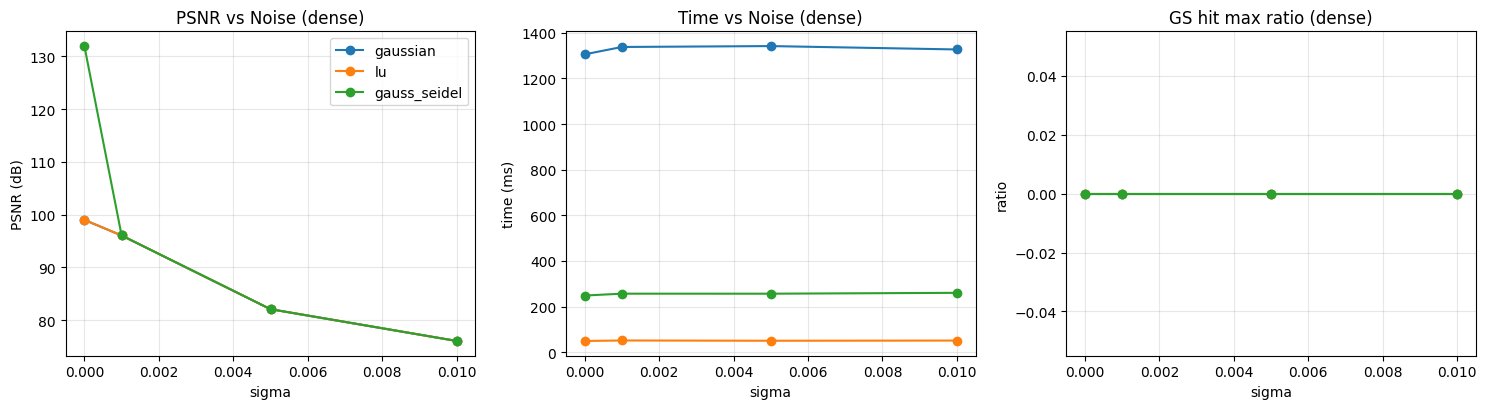

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\metrics_dense.png


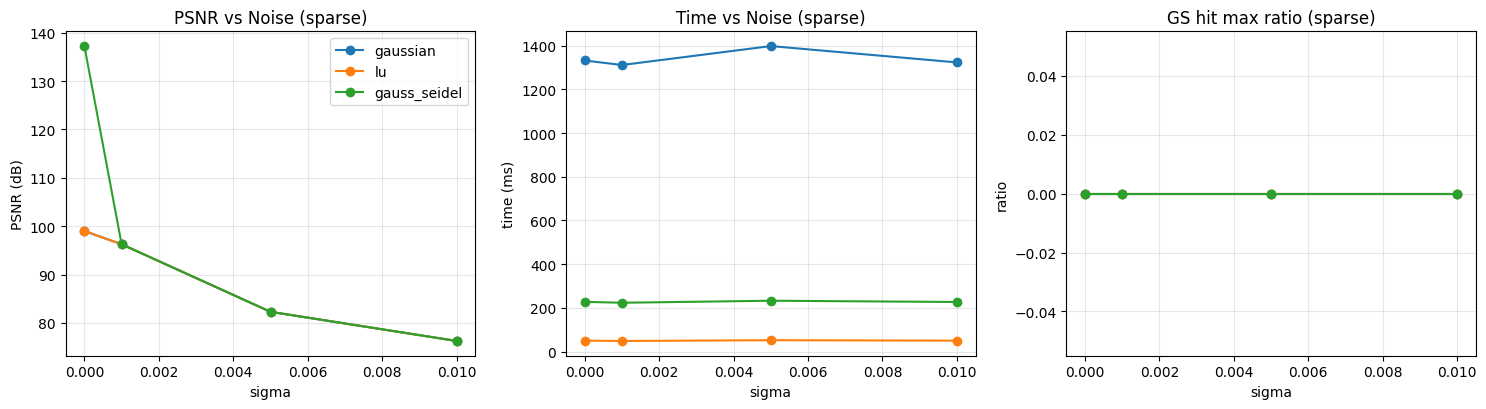

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\metrics_sparse.png


In [10]:
solver_order = ["gaussian", "lu", "gauss_seidel"]
color_map = {"gaussian": "tab:blue", "lu": "tab:orange", "gauss_seidel": "tab:green"}

for matrix_type in ["dense", "sparse"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

    for solver in solver_order:
        rows = [r for r in summary_rows if r["matrix_type"] == matrix_type and r["solver"] == solver]
        rows = sorted(rows, key=lambda x: x["sigma"])
        x = [r["sigma"] for r in rows]

        axes[0].plot(x, [r["psnr_mean"] for r in rows], marker="o", label=solver, color=color_map[solver])
        axes[1].plot(x, [r["time_ms_mean"] for r in rows], marker="o", label=solver, color=color_map[solver])
        axes[2].plot(x, [r["gs_hit_max_ratio_mean"] for r in rows], marker="o", label=solver, color=color_map[solver])

    axes[0].set_title(f"PSNR vs Noise ({matrix_type})")
    axes[0].set_xlabel("sigma")
    axes[0].set_ylabel("PSNR (dB)")

    axes[1].set_title(f"Time vs Noise ({matrix_type})")
    axes[1].set_xlabel("sigma")
    axes[1].set_ylabel("time (ms)")

    axes[2].set_title(f"GS hit max ratio ({matrix_type})")
    axes[2].set_xlabel("sigma")
    axes[2].set_ylabel("ratio")

    for a in axes:
        a.grid(True, alpha=0.3)

    axes[0].legend()
    fig.tight_layout()
    path = FIG_DIR / f"metrics_{matrix_type}.png"
    fig.savefig(path, dpi=180)
    plt.show()
    print("Saved:", path)


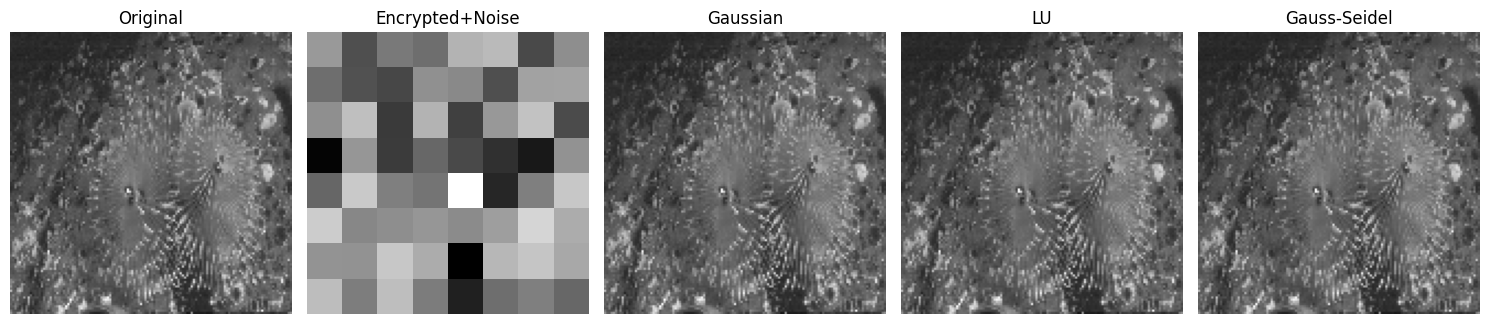

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\wall_of_decryption_dense.png


In [11]:
# Representative visual comparisons (5 exported panels)

def make_wall(matrix_type, A, img_idx, sigma, case_idx):
    img = images[img_idx % len(images)]
    blocks = split_blocks(img, CONFIG["block_size"])
    encrypted = blocks @ A.T
    noisy = encrypted + sigma * rng.standard_normal(encrypted.shape)

    def reconstruct_with(solver_name):
        dec_blocks, _, _, _ = decrypt_blocks(
            A,
            noisy,
            solver_name,
            gs_tol=CONFIG["gs_tol"],
            gs_max_iters=CONFIG["gs_max_iters"],
        )
        return merge_blocks(dec_blocks, img.shape[0], img.shape[1], CONFIG["block_size"])

    rec_g = reconstruct_with("gaussian")
    rec_lu = reconstruct_with("lu")
    rec_gs = reconstruct_with("gauss_seidel")

    enc_view = minmax01(
        noisy.reshape(-1, CONFIG["block_size"], CONFIG["block_size"]).mean(axis=0)
    )

    fig, ax = plt.subplots(1, 5, figsize=(15, 3.5))
    fig.suptitle(f"{matrix_type} | image={img_idx} | sigma={sigma}", fontsize=11)
    ax[0].imshow(img, cmap="gray", vmin=0, vmax=1)
    ax[0].set_title("Original")
    ax[1].imshow(enc_view, cmap="gray", vmin=0, vmax=1)
    ax[1].set_title("Encrypted+Noise")
    ax[2].imshow(rec_g, cmap="gray", vmin=0, vmax=1)
    ax[2].set_title("Gaussian")
    ax[3].imshow(rec_lu, cmap="gray", vmin=0, vmax=1)
    ax[3].set_title("LU")
    ax[4].imshow(rec_gs, cmap="gray", vmin=0, vmax=1)
    ax[4].set_title("Gauss-Seidel")

    for a in ax:
        a.axis("off")

    fig.tight_layout(rect=[0, 0.03, 1, 0.92])

    sigma_tag = str(sigma).replace(".", "p")
    out_path = FIG_DIR / f"wall_{case_idx + 1:02d}.png"
    fig.savefig(out_path, dpi=180)
    plt.show()
    print("Saved:", out_path)
    return out_path


sigmas = sorted(CONFIG["noise_sigmas"])
s0 = sigmas[0]
s1 = sigmas[min(1, len(sigmas) - 1)]
s2 = sigmas[-1]

cases = [
    ("dense", A_dense, 0, s0),
    ("dense", A_dense, 1, s1),
    ("dense", A_dense, 2, s2),
    ("sparse", A_sparse, 0, s0),
    ("sparse", A_sparse, 1, s2),
]

wall_outputs = []
for case_idx, (matrix_type, A, img_idx, sigma) in enumerate(cases):
    wall_outputs.append(make_wall(matrix_type, A, img_idx, sigma, case_idx))

print("Generated", len(wall_outputs), "wall images")


## Output Files

After running all cells:
- `out/config.json`
- `out/results_detail.csv`
- `out/results_summary.csv`
- `out/tables/table_dense_sigma.tex`
- `out/tables/table_sparse_sigma.tex`
- `out/figures/metrics_dense.png`
- `out/figures/metrics_sparse.png`
- `out/figures/wall_01.png` ... `out/figures/wall_05.png`

To use your own images:
1. Put files in `data/custom_images`
2. Keep `CONFIG["data_source"] = "custom"`
3. Run all cells
